# Text mining
## Homework 01 Feature Selection

In this homework covers three aspects:
1. Text pre-processing (tokenization, lemmatization, stemming, stop words removal, etc.)
2. Feature selection (in our case only token selection).

You will find the steps you need to perform in the **Task** section in each cell, and fill the code snippets marked with `...`. 

In [1]:
# Standard python modules 
import string
import math
from collections import Counter
from itertools import chain

# Custom installed packages (Colab have them pre-installed)
# if you need anything else you can use !pip install YOUR_PACKAGE
import nltk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from nltk import everygrams
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tqdm.auto import tqdm

# Required for running the nltk modules that we are going to use.
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# TF.IDF class implementation

In this paragraph we are going to create a new class that handles the data processing, cleaning and transformation. Our main goal is to create fit() and transform() methods similar to  [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer)

## Tasks:

1. Find suitable Lemmatizer and Stemmer from the [NLTK](https://www.nltk.org/) library (recommended WordNet Lemmatizer and Snowball Stammer)
2. Implement missing transformations in preprocess. For stop words you can use again a pre-defined list from NLTK
3. Create N-grams from the single tokens generated by the tokenizer (You will need all n-grams from min_n to max_n)
4. Calculate the idf values using the formulas from below and store then into the self.idf_vec property

**Term Frequency (tf)**: gives us the frequency of the word in each document in the corpus. It is the ratio of number of times the word appears in a document compared to the total number of words in that document. It increases as the number of occurrences of that word within the document increases. Each document has its own tf.

$tf_{i,j} = \frac{n_{i,j}}{\sum_k{n_{i, j}}}$

**Inverse Data Frequency (idf)**: used to calculate the weight of rare words across all documents in the corpus. The words that occur rarely in the corpus have a high IDF score. It is given by the equation below.

$idf(w) = log(\frac{N}{df_t})$

Combining these two we come up with the TF-IDF score (w) for a word in a document in the corpus. It is the product of tf and idf:

$w_{i,j} = tf_{i,j} \times  log(\frac{N}{df_i}) $

Where:

*  $tf_{i,j}$  - number of occurences of term $i$ in document $j$
*  $df_{i}$  - number of document containing term $i$
* $N$ - total number of documents in the corpus

Expected output after tokenization, stop words are not removed:

`He was running and eating at same time . He has bad habit of swimming after playing long hours in the Sun`. 
```
Pre-processed
Tokens              Lemma               Stem                
He                  He                  he                  
was                 be                  was                 
running             run                 run                 
and                 and                 and                 
eating              eat                 eat                 
at                  at                  at                  
same                same                same                
time                time                time                
He                  He                  he                  
has                 have                has                 
bad                 bad                 bad                 
habit               habit               habit               
of                  of                  of                  
swimming            swim                swim                
after               after               after               
playing             play                play                
long                long                long                
hours               hours               hour                
in                  in                  in                  
the                 the                 the                 
Sun                 Sun                 sun    
```

In [2]:
class TfIdf:
  def __init__(self, 
               opt='stem',
               lower=True,
               remove_stop_words=True,
               remove_punkt=True,
               min_n = 1,
               max_n = 2,
               max_words = 1000):
    
    self.opt=opt
    self.lower=lower
    self.remove_stop_words=remove_stop_words
    self.remove_punkt=remove_punkt
    self.min_n = min_n
    self.max_n = max_n
    self.max_words = max_words
    self.word_freq = None
    self.idf = None
    self.tfidf = None
    
    self.wordnet_lemmatizer = WordNetLemmatizer()
    self.snowball_stem = SnowballStemmer("english")
    self.stop_words = set(stopwords.words("english"))

  def preprocess(self, sent):
    if self.lower:
      # Convert the sentence to lower case
      sent = sent.lower()

    words = nltk.word_tokenize(sent)
    if self.opt == "stem":
      # Stem words
      words = [self.snowball_stem.stem(word) for word in words]
    elif self.opt == "lem":
      # Lemmatize words
      words = [self.wordnet_lemmatizer.lemmatize(word) for word in words]

    if self.remove_stop_words:
      # Filter stop words
      words = [word for word in words if not word in self.stop_words]

    if self.remove_punkt:
      # Filter punctuation (you may use string.punctuation)
      words = [word for word in words if not word in string.punctuation]

    # Generate N-grams                                                   
    result = []
    for i in range(self.min_n, self.max_n + 1):
      result += nltk.ngrams(words, i)                                                                                                                    
    words = result
    return words

  def fit(self, data):
    self.word_freq = Counter()
    
    N = len(data)
    
    for sent in tqdm(data):
      words = self.preprocess(sent)
      for w in set(words):
        self.word_freq[w] += 1

    self.vocab = [w[0] for w in self.word_freq.most_common()[:self.max_words]]
    self.reverse_vocab = dict(zip(self.vocab, range(len(self.vocab))))
    
    # Calculate IDF using the formulas in the description
    
    idfs = []
    for word in self.vocab:
      tmp_idf = np.log(N/self.word_freq[word])
      idfs.append(tmp_idf)

    self.idf = np.array(idfs)

    # Added a mechansim to calculate the TFIDF using the formulas in the description
    self.tfidf = np.zeros(len(self.vocab), dtype=np.float32)

    for i, sent in enumerate(data):
      words = self.preprocess(sent)
      for word in set(words):
        if word in self.vocab:
          tf = words.count(word) / len(words)
          idf = self.idf[self.reverse_vocab[word]]
          self.tfidf[self.reverse_vocab[word]] += tf * idf

  def transform(self, data):
    # Provided an implementation for our case when we pass a word (which is a tuple of 2 elements) and we return its TF-IDF  
    # Provided an implementation also if we pass sentences in the data and we return a matrix as this was part of the comment in the homework. 
    tfidf_res = np.zeros((len(data), len(self.vocab)), dtype=np.float32)

    single_word = False
    if isinstance(data, tuple):
      single_word = True

    if single_word:
      if data in self.vocab:
        tfidf_res[0][self.reverse_vocab[data]] = self.tfidf[self.reverse_vocab[data]]
        return tfidf_res[0][self.reverse_vocab[data]]
      else:
        return 0
    else:
      for i, sent in enumerate(data):
        words = self.preprocess(sent)
        for word in set(words):
          if word in self.vocab:
            idf = self.idf[self.reverse_vocab[word]]
            # print("IDF ", idf, " for word ", w)
            tfidf_res[i][self.reverse_vocab[word]] = self.tfidf[self.reverse_vocab[word]]
      return tfidf_res



# Data Loading 
We are going to use the 20newsgroup dataset.

First we use the [fetch_20newgroup](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups) module from sklearn. 

In [3]:
print('Loading data...')

categories = ['alt.atheism', 'talk.religion.misc',
              'comp.graphics', 'sci.space']
# We load the data for each category, and create a custom tf-idf object 
# This will allow us to calculate the feature metics later.
tfidfs = {}
for category in categories:
  tfidfs[category] = TfIdf()
  tfidfs[category].fit(fetch_20newsgroups(subset='train', categories=[category]).data)

# Create a TfIdf object that includes examples from all the classes
tfidfs["all"] = TfIdf()
tfidfs["all"].fit(fetch_20newsgroups(subset='train', categories=categories).data)

Loading data...


  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/377 [00:00<?, ?it/s]

  0%|          | 0/584 [00:00<?, ?it/s]

  0%|          | 0/593 [00:00<?, ?it/s]

  0%|          | 0/2034 [00:00<?, ?it/s]

In [ ]:
fetch_20newsgroups(subset='train', categories=[category]).data

# Feature Selection

Here, the goal is to calculate four different measurements for token importance. Then we will fill a Pandas DataFrame with one row for each token, and one column for each measure. In the notation below: `P` is a probability, `c` is the class, `t` is the token.

The formulas and a worked out examples are given in the lecture.

# IDF
It has been calculated in the `TfIdf` object, we need to retrieve it.

# Chi-Squared ($\chi^2$)

$ \chi^2(c, t) = \sum{\frac{(O - E)^2}{E}}$, where `E` is the expected value, and `O` is the observed (the value in the cells).

This is done for each cell in the 2x2 matrix that has rows the counts of examples in $class$, and $\neg{class}$ (not `class`), and intersected with the columns $token$, and $\neg{token}$.

An additional numeric example can be found [here](https://www.mathsisfun.com/data/chi-square-test.html).

**Note:** this is calculated per-class, you need to do an average.

$\chi^2_{avg}(t) = \sum{P(c_i) * \chi^2(c, t)}$

# Information Gain
The amount of information gained about a random variable or signal from observing another random variable.

$G(t) = -\sum{P(c_i) \log{P(c_i)}} + P(t)\sum{P(c_i|t) \log{P(c_i|t)}} + P(\neg{t})\sum{P(c_i|\neg{t}) \log{P(c_i|\neg{t})}}$

## Mutual Information

Mutual Information quantifies the "amount of information" (in units such as shannons, commonly called bits) obtained about one random variable through observing the other random variable.

$MI(t,c) = \log{\frac{P(t,c)}{P(t)P(c)}} = ... = \log{P(t|c)} - \log{P(t)}$,
using the definition of conditional probability $P(t|c) = \frac{P(t,c)}{P(c)}$.

# Tasks
1. Calculate all the feature selection metrics for each token
2. Convert them to a Pandas DataFrame
3. Run the code for plotting in the cell below

In [4]:
def get_word_stats(tfidfs, categories, word):
  # May include other relevant metrics, as total examples, etc.
  w_stats = {}

  for category in categories: 
    word_count = sum(tfidfs[category].transform(w) for w in tfidfs[category].vocab)
    tmp_it = iter([cat for cat in categories if cat != category])
    w_stats[category] = {
        # Number of time the token `t` was seen in the categories `c`
        "t_c": tfidfs[category].transform(word),
        # Number of time the token `t` was seen another categories NOT `c`
        "t_Nc": (tfidfs[next(tmp_it)].transform(word) +  tfidfs[next(tmp_it)].transform(word) + tfidfs[next(tmp_it)].transform(word)),
        # Number of tokens in the categories c (that are NOT token `t`)
        "Nt_c": word_count - tfidfs[category].transform(word),
        # Number of tokens (that are NOT token `t`) in other categories (NOT `c`)
        "Nt_Nc": sum(sum(tfidfs[c].transform(w) for w in tfidfs[c].vocab if w != word) for c in categories if c != category),
    }

  return w_stats

def calc_chisq(w_stats):
  chi_sq = 0
  # epsilon is intorduced in order not to have a division by 0 
  epsilon = 1e-8 

  # Calculate the Chi-Squared using the formulas in the description
  for category in w_stats.keys():
    O_t_c = w_stats[category]['t_c']
    O_t_Nc = w_stats[category]['t_Nc']
    O_Nt_c = w_stats[category]['Nt_c']
    O_Nt_Nc = w_stats[category]['Nt_Nc']

    total = O_t_c + O_t_Nc + O_Nt_c + O_Nt_Nc

    E_t_c = ((O_t_c + O_t_Nc) * (O_t_c + O_Nt_c) + epsilon) / (total + epsilon)
    E_t_Nc = ((O_t_c + O_t_Nc) * (O_t_Nc + O_Nt_Nc) + epsilon) / (total + epsilon)
    E_Nt_c = ((O_Nt_c + O_Nt_Nc) * (O_t_c + O_Nt_c) + epsilon) / (total + epsilon)
    E_Nt_Nc = ((O_Nt_c + O_Nt_Nc) * (O_t_Nc + O_Nt_Nc) + epsilon) / (total + epsilon)

    P_ci = (O_t_c + O_Nt_c) / total
    chi_sq_t_c =  (O_t_c - E_t_c) ** 2 / E_t_c 
    chi_sq_t_Nc = (O_t_Nc - E_t_Nc) ** 2 / E_t_Nc 
    chi_sq_Nt_c = (O_Nt_c - E_Nt_c) ** 2 / E_Nt_c 
    chi_sq_Nt_Nc = (O_Nt_Nc - E_Nt_Nc) ** 2 / E_Nt_Nc

    chi_sq_avg_ci = P_ci * chi_sq_t_c + P_ci * chi_sq_t_Nc + P_ci * chi_sq_Nt_c + P_ci * chi_sq_Nt_Nc
    chi_sq += chi_sq_avg_ci

  return chi_sq 

def calc_infogain(w_stats):
  g_t = 0
  # epsilon is intorduced in order not to have a division by 0 or log(0)
  epsilon = 1e-8

  # Calculate the Information Gain using the formulas in the description
  for category in w_stats.keys():
    num_t_c = w_stats[category]['t_c'] 
    num_t_Nc = w_stats[category]['t_Nc'] 
    num_Nt_c = w_stats[category]['Nt_c']
    num_Nt_Nc = w_stats[category]['Nt_Nc']

    total = num_t_c + num_Nt_c + num_t_Nc + num_Nt_Nc 
    P_t_c = num_t_c / total
    P_t_Nc = num_t_Nc / total
    P_Nt_c = num_Nt_c / total
    P_Nt_Nc = num_Nt_Nc / total

    P_c = (num_t_c + num_Nt_c) / total 

    P_t = (num_t_c + num_t_Nc) / total
    P_Nt = (num_Nt_c + num_Nt_Nc) / total
      
    g_t += -P_c * np.log(P_c + epsilon) + P_t * (P_t_c / (P_t + epsilon)) * np.log((P_t_c + epsilon) / (P_t + epsilon)) + P_Nt * (P_Nt_c / (P_Nt + epsilon)) * np.log((P_Nt_c + epsilon) / (P_Nt + epsilon)) 
  return g_t

def calc_mutualinformation(w_stats):
  mi_t = 0
  num_c = 0
  # epsilon is intorduced in order not to have a division by 0 or log(0)
  epsilon = 1e-8
  
  # Calculate the MI using the formulas in the description
  for category in w_stats.keys():
    num_t_c = w_stats[category]['t_c']  
    num_t_Nc = w_stats[category]['t_Nc'] 
    num_Nt_c = w_stats[category]['Nt_c']
    num_Nt_Nc = w_stats[category]['Nt_Nc']

    total = num_t_c + num_Nt_c + num_t_Nc + num_Nt_Nc 
    P_t_c = num_t_c / total
    P_c = (num_t_c + num_Nt_c) / total
    P_t = (num_t_c + num_t_Nc) / total

    mi_t += np.log((P_t_c + epsilon) / (P_c + epsilon)) - np.log(P_t + epsilon)
  
  return mi_t / 4
  
feature_selection = {}
for w, idx in tqdm(tfidfs["all"].reverse_vocab.items()):
  w_stats = get_word_stats(tfidfs, categories, w) 
  feature_selection[w] = {
      "Chi Squared": calc_chisq(w_stats),
      "Information Gain":  calc_infogain(w_stats),
      "Mutual Information": calc_mutualinformation(w_stats),
      "IDF": tfidfs["all"].idf[idx],
  }

feature_selection_df = pd.DataFrame.from_dict(feature_selection)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
feature_selection_df

,subject,line,organ,write,--,'','s,n't,``,articl,...,matthew,repeat,god,share,class,radio,fire,schneider,stephen,dave
,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,'',NaN,NaN,NaN,NaN,subject,NaN,NaN
Chi Squared,1.270330e-11,0.004836,0.006688,0.088539,1.658024,0.020400,0.004309,0.012909,0.004630,0.008258,...,0.213166,0.100980,0.266647,0.083867,0.150525,0.487206,0.448777,0.648409,0.437544,0.211220
Information Gain,3.674179e-09,0.000004,0.000009,0.000082,0.001372,0.000020,0.000005,0.000013,0.000006,0.000008,...,0.000207,0.000108,0.000291,0.000112,0.000212,0.000410,0.000435,0.000561,0.000424,0.000275
Mutual Information,1.406384e+00,-2.910094,-0.094931,-0.070262,-0.160987,-0.000267,-0.013190,-0.019859,0.009959,-0.005383,...,-5.629370,-3.686732,-4.179058,-3.862481,-4.221087,-6.367022,-6.187579,-6.544183,-6.168572,-4.313087
IDF,0.000000e+00,0.000492,0.040638,0.478893,0.597569,0.601150,0.652679,0.655516,0.674637,0.717029,...,3.685934,3.685934,3.685934,3.685934,3.685934,3.685934,3.685934,3.685934,3.705737,3.705737


In [ ]:
feature_selection_df.shape

(4, 1000)

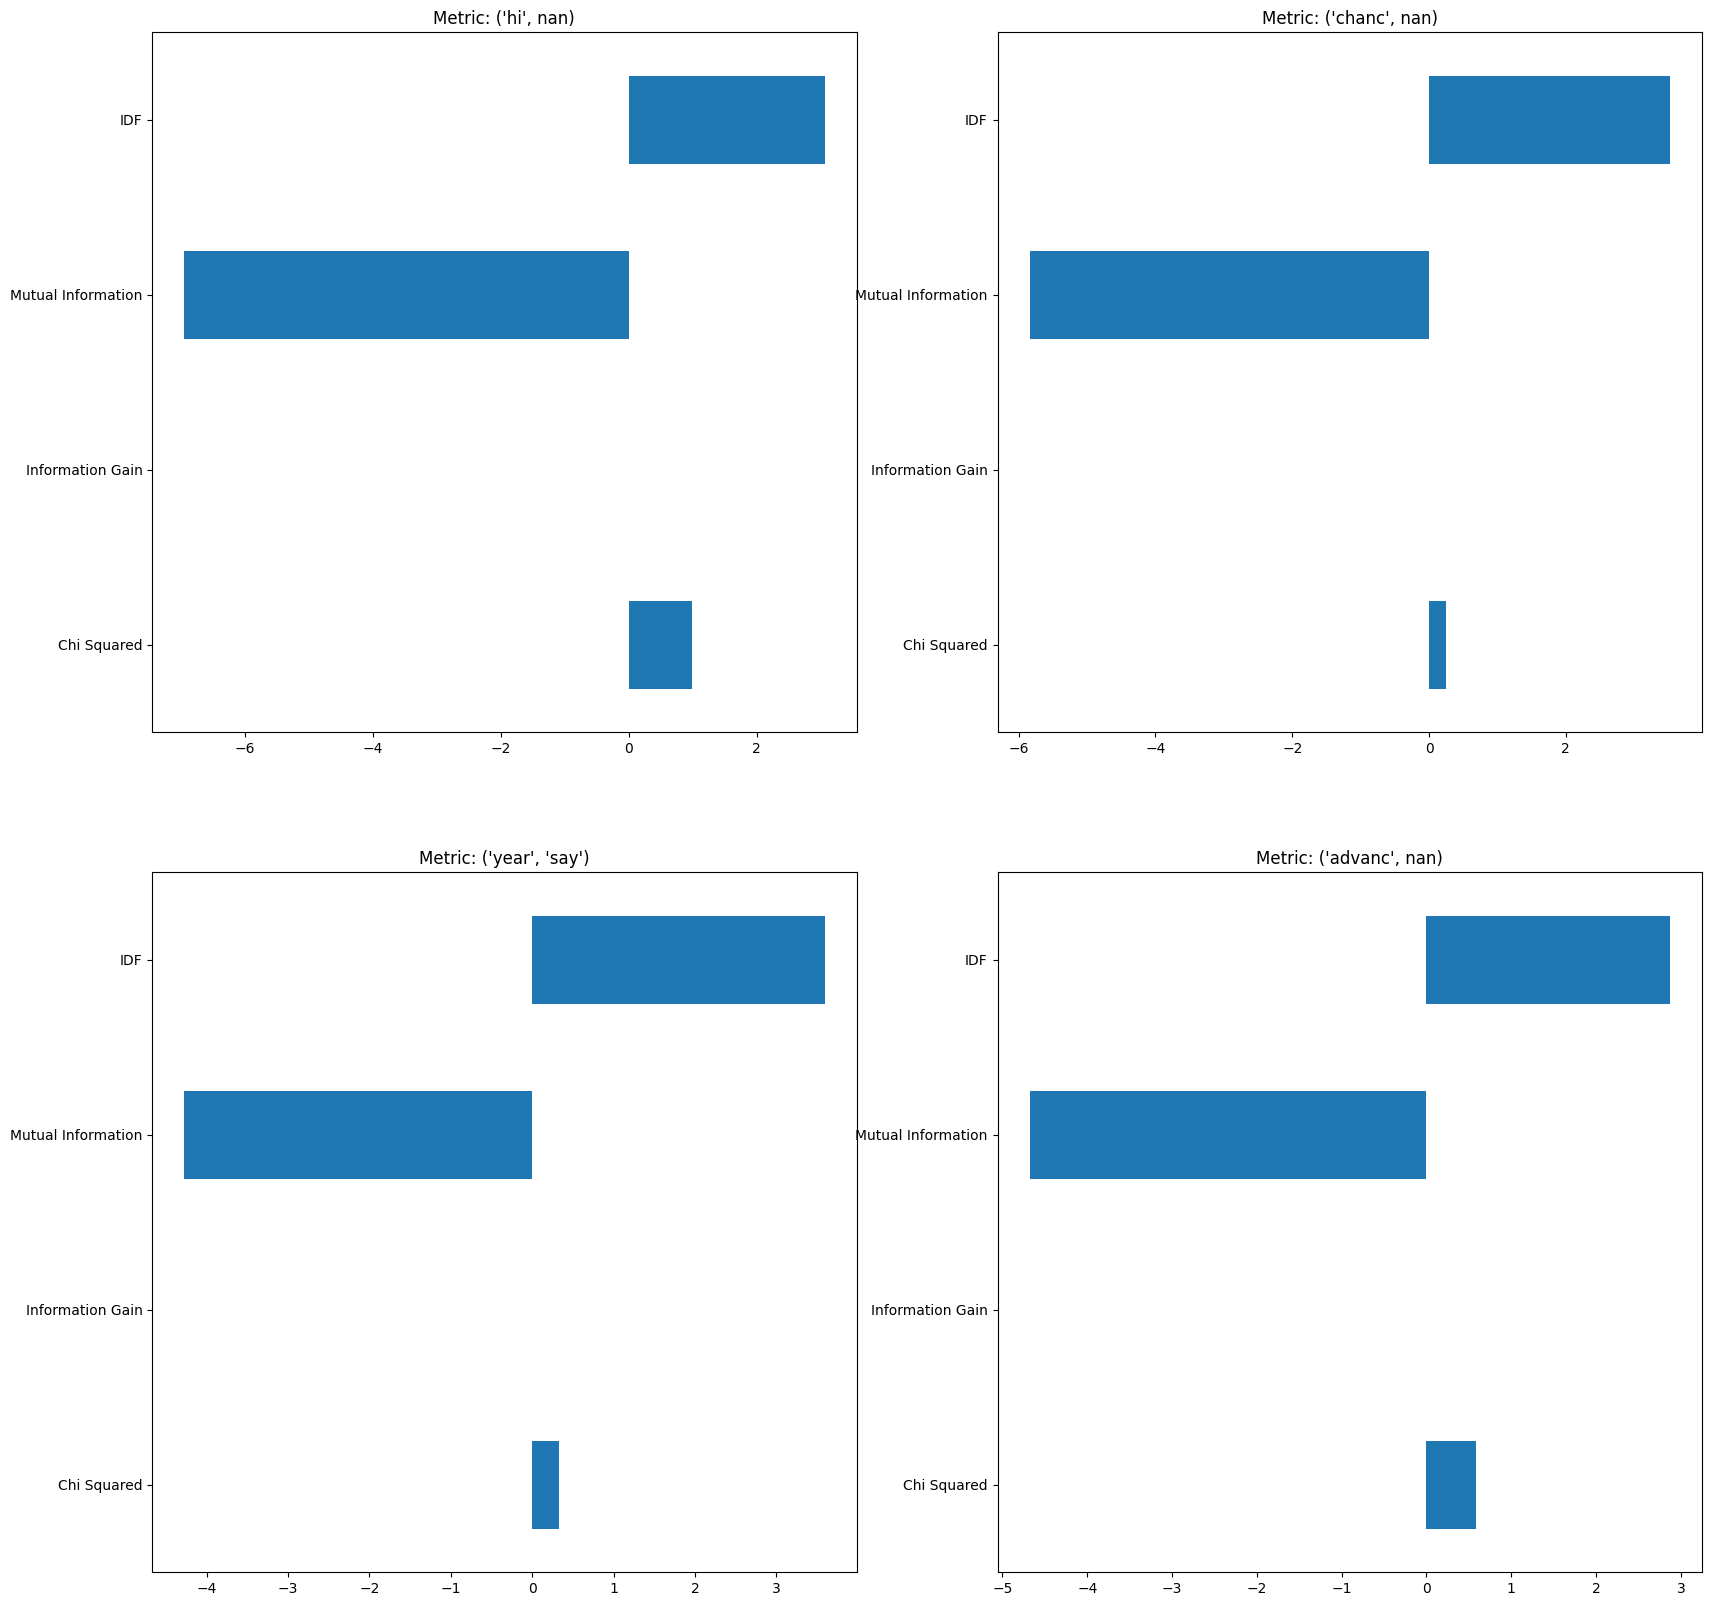

In [6]:
# We have the statistics in the rows and the words in the columns. We need to transpose the DataFrame first, sample the N words and transpose it back
transposed_df = feature_selection_df.T

# Sample N words
sampled_df = transposed_df.sample(min(10, len(transposed_df)))

sampled_df = sampled_df.T

# This works for four categores 2x2, if you add -- change nrows/ncols
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
#This is a 2D array with size nrows x nccols
#We flatten it just for convenience
axes = chain(*axes)


# For each column plot the metrics for the sampled words.
for col, ax in zip(sampled_df.columns, axes):
  sampled_df[col].plot.barh(ax=ax, title=f"Metric: {col}")

In [7]:
feature_selection[('hi',)]

{'Chi Squared': 0.9955358024846046,
 'Information Gain': 0.0008214821292528152,
 'Mutual Information': -6.946662312160663,
 'IDF': 3.0638826850079646}